In [3]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


In [4]:
import optuna 

In [5]:
import pandas as pd
import numpy as np
import math

import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count 
from joblib import Parallel 
from joblib import delayed 
from datetime import datetime



from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import SGD



In [ ]:
s11 = pd.read_csv('s11.csv', header = 0, infer_datetime_format=True, index_col=['TIMESTAMP']).drop('Unnamed: 0', axis=1).reset_index()
df = s11[[
       'S11_Top_Temp_Avg', 'S11_Top_VWC_Avg'
       
       ]]



In [ ]:


def split_dataset(data):
  """
    Splits the dataset into train and test sets.
    
    Args:
        data (array): The dataset to be split.
        
    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  train, test = data[0:288], data[288:576]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    """
    Converts the input data into a supervised learning format.
    
    Args:
        train (array): The training dataset.
        n_input (int): The number of input time steps.
        
    Returns:
        X (array): The input features for supervised learning.
        y (array): The target values for supervised learning.
    """
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0]) 
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)

def build_moe_model_with_autoencoder_cnn_attention(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts, learning_rate, activation, kernel_initializer, dropout_rate,
                                     num_iterations=100):
    """
    Builds a Mixture of Experts (MoE) model with autoencoder, CNN and attention mechanisms.
    
    Args:
        input_dim (int): The dimension of input features.
        output_dim (int): The dimension of output features.
        expert_hidden_sizes (list): The hidden layer sizes for each expert.
        expert_output_sizes (list): The output layer sizes for each expert.
        gating_hidden_sizes (list): The hidden layer sizes for the gating network.
        num_experts (int): The number of experts in the model.
        learning_rate (float): The learning rate for the optimizer.
        activation (str): The activation function to be used in the hidden layers.
        kernel_initializer (str): The kernel initializer for the layers.
        dropout_rate (float): The dropout rate for dropout layers.
        num_iterations (int, optional): The number of iterations for training. Defaults to 100.
        
    Returns:
        moe_model (Model): The Mixture of Experts model.
        experts (list): The list of expert models.
        gating_model (Model): The gating network model.
    """
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        elif i == 1:  # Replace second expert with a Transformer expert
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
            expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[i])(expert_hidden, expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with a GRU-based model
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
            expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output[:, :1] for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    """
    Defines the loss function for the Mixture of Experts (MoE) model.
    
    Args:
        y_true (tensor): The true target values.
        y_pred (tensor): The predicted target values.
        gating_output (tensor): The output of the gating network.
        
    Returns:
        (tensor): The calculated MoE loss.
    """
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)

def scheduler(epoch, lr):
    """
    Custom learning rate scheduler.
    
    Args:
        epoch (int): The current epoch.
        lr (float): The current learning rate.
        
    Returns:
        (float): The updated learning rate.
    """
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def sliding_window_split(data, window_size, step_size):
    """
    Splits the input data into sliding windows of specified size and step size.
    
    Args:
        data (array): The input data to be split.
        window_size (int): The size of the sliding window.
        step_size (int): The step size for sliding the window.
        
    Returns:
        windowed_data (list): A list of arrays containing the data split into sliding windows.
    """
    windowed_data = []
    for i in range(0, len(data) - window_size, step_size):
        windowed_data.append(data[i:i + window_size])
    return windowed_data

def save_best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        # Save the best model
        best_model = trial.user_attrs['model']
        model_path = f'best_model_s11_{trial.number}.h5'
        best_model.save(model_path)
        print(f"Best model saved to {model_path}")

In [ ]:
def objective(trial, train_input, train_output, input_dim, output_dim):
    # Define the hyperparameters to optimize using Optuna
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['glorot_normal', 'he_normal', None])

    window_size = 500
    step_size = 50

    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]

    # Define the sizes of the gating network hidden layers
    gating_hidden_sizes = [16, 8]

    # Define the size of the output layer of the gating network
    gating_output_size = num_experts

    # Define the number of training iterations for the EM algorithm
    num_iterations = 10

    # Load the training data
    train_data = np.array(df.head(10000))


    # Split the training data into input and output sequences
    train_input = train_data[:, :]
    print('train_input shape', train_input.shape)
    train_output = train_data[:, -1:]
    print('train_output shape', train_output.shape)


    # Normalize input data
    train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)


    train_input_windows = sliding_window_split(train_input, window_size, step_size)
    train_output_windows = sliding_window_split(train_output, window_size, step_size)

    # Build and train the model using the hyperparameters
    moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
        input_dim,
        output_dim,
        expert_hidden_sizes,
        expert_output_sizes,
        gating_hidden_sizes,
        num_experts,
        learning_rate,
        activation,
        kernel_initializer,
        dropout_rate)

    # Define the optimization algorithm
    optimizer = Adam(learning_rate=learning_rate)

    # Learning rate scheduler
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the MoE model with the EM algorithm
    iteration = 0
    while iteration < num_iterations:
        num_train_windows = int(0.8 * len(train_input_windows))
        for window_idx in range(len(train_input_windows)):

          # E step: Compute the responsibilities of each expert for each data point
          gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
          gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

          # M step: Update the parameters of each expert and the gating network
          for i in range(num_experts):
              expert_input = train_input
              expert_output = experts[i](expert_input)
              expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

              with tf.GradientTape() as tape:
                  # Watch the trainable variables of the expert model
                  tape.watch(experts[i].trainable_variables)

                  # Define the expert model and calculate the expert_loss
                  expert_output = experts[i](expert_input)
                  expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

              # Compute the gradients
              expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
              # Clip gradients for expert models
              expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

              # Update the variables
              optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
          
          current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
          optimizer.learning_rate.assign(current_learning_rate)

          gating_input = train_input

          with tf.GradientTape() as tape:
              # Watch the trainable variables of the gating model
              tape.watch(gating_model.trainable_variables)

              # Define the gating model and calculate the gating_loss
              gating_output = gating_model(gating_input)
              gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


          # Compute the gradients
          gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
          # Clip gradients for the gating model
          gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

          # Update the variables
          optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

          # Evaluate the performance of the MoE model on the training set
          if window_idx < num_train_windows:
            train_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            print(f'Iteration {iteration + 1}, Training window {window_idx + 1}: Training loss = {train_loss:.6f}')
          else:
            val_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            print(f'Iteration {iteration + 1}, Validation window {window_idx - num_train_windows + 1}: Validation loss = {val_loss:.6f}')

        # Stop training if the learning rate becomes too small
        if current_learning_rate < 1e-6:
            print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
            break

        iteration += 1
    trial.set_user_attr('model', moe_model)
    return train_loss


In [ ]:
from functools import partial

# Load the training data
train_data = np.array(df.head(10000))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3
objective_with_args = partial(objective, train_input=train_input, train_output=train_output, input_dim=input_dim, output_dim=output_dim)
study = optuna.create_study(direction="minimize")
study.optimize(objective_with_args, n_trials=5, callbacks=[save_best_model_callback])



[I 2023-04-26 13:40:40,792] A new study created in memory with name: no-name-03ca947c-2e09-4769-81f8-25ae40b5cbc6


train_input shape (10000, 2)
train_output shape (10000, 1)
train_input shape (10000, 2)
train_output shape (10000, 1)


<ipython-input-8-85972daf6b4c>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-8-85972daf6b4c>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Streaming output truncated to the last 5000 lines.
Iteration 4, Training window 80: Training loss = 17.164150
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 3.559524
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 82: Training loss = 4.162226
16/16 [==============================] - 0s 4ms/step
Iteration 4, Training window 83: Training loss = 7.991332
16/16 [==============================] - 0s 4ms/step
Iteration 4, Training window 84: Training loss = 3.847904
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 0.281119
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 0.252365
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 87: Training loss = 0.252151
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss = 0.263092
16

[I 2023-04-26 14:28:00,191] Trial 0 finished with value: 0.8006081581115723 and parameters: {'dropout_rate': 0.12802615620965968, 'learning_rate': 0.0010699097442621974, 'activation': 'relu', 'kernel_initializer': 'he_normal'}. Best is trial 0 with value: 0.8006081581115723.


Streaming output truncated to the last 5000 lines.
Iteration 4, Training window 80: Training loss = 437.157227
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 81: Training loss = 410.044403
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 82: Training loss = 309.357574
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 83: Training loss = 228.950607
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 84: Training loss = 136.325241
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 43.729843
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 43.239498
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 47.014462
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 88: Training loss =

[I 2023-04-26 15:16:13,799] Trial 1 finished with value: 161.50523376464844 and parameters: {'dropout_rate': 0.22851560833880258, 'learning_rate': 1.028618405976286e-05, 'activation': 'sigmoid', 'kernel_initializer': None}. Best is trial 0 with value: 0.8006081581115723.


Streaming output truncated to the last 5000 lines.
Iteration 4, Training window 80: Training loss = 290.325012
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 284.639343
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 82: Training loss = 223.907608
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 83: Training loss = 169.709244
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 84: Training loss = 100.783524
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 31.757866
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 31.622622
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 34.013924
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss =

[I 2023-04-26 16:03:25,592] Trial 2 finished with value: 70.94109344482422 and parameters: {'dropout_rate': 0.48629713599587787, 'learning_rate': 2.5094468986998946e-05, 'activation': 'sigmoid', 'kernel_initializer': None}. Best is trial 0 with value: 0.8006081581115723.


Streaming output truncated to the last 5000 lines.
Iteration 4, Training window 80: Training loss = 45825.238281
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 45717.257812
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 82: Training loss = 27389.753906
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 83: Training loss = 19049.107422
16/16 [==============================] - 0s 3ms/step
Iteration 4, Training window 84: Training loss = 12366.958984
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 28.612648
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 28.302423
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 29.322292
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Train

[I 2023-04-26 16:53:41,765] Trial 3 finished with value: 237.32257080078125 and parameters: {'dropout_rate': 0.027773744613400375, 'learning_rate': 3.715526693996133e-05, 'activation': 'relu', 'kernel_initializer': 'he_normal'}. Best is trial 0 with value: 0.8006081581115723.


Streaming output truncated to the last 5000 lines.
Iteration 4, Training window 80: Training loss = 1.677439
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 81: Training loss = 1.912291
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 82: Training loss = 1.431231
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 83: Training loss = 1.307167
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 84: Training loss = 1.240803
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 85: Training loss = 0.707513
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 86: Training loss = 0.596010
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 87: Training loss = 0.327739
16/16 [==============================] - 0s 2ms/step
Iteration 4, Training window 88: Training loss = 0.263196
16/

[I 2023-04-26 17:46:19,430] Trial 4 finished with value: 0.4985397160053253 and parameters: {'dropout_rate': 0.2289625060750154, 'learning_rate': 0.0008599429411664891, 'activation': 'sigmoid', 'kernel_initializer': 'glorot_normal'}. Best is trial 4 with value: 0.4985397160053253.


Iteration 10, Validation window 38: Validation loss = 0.937175


In [ ]:
study.best_params

{'dropout_rate': 0.2289625060750154,
 'learning_rate': 0.0008599429411664891,
 'activation': 'sigmoid',
 'kernel_initializer': 'glorot_normal'}

train_input shape (10000, 2)
train_output shape (10000, 1)
313/313 [==============================] - 0s 1ms/step
Iteration 1: Training loss = 471.877350
313/313 [==============================] - 1s 2ms/step
Iteration 2: Training loss = 304.173187
313/313 [==============================] - 0s 1ms/step
Iteration 3: Training loss = 192.550797
313/313 [==============================] - 0s 1ms/step
Iteration 4: Training loss = 254.559631
313/313 [==============================] - 0s 1ms/step
Iteration 5: Training loss = 564.187073
313/313 [==============================] - 0s 1ms/step
Iteration 6: Training loss = 1078.284058
313/313 [==============================] - 0s 1ms/step
Iteration 7: Training loss = 2020.668823
313/313 [==============================] - 1s 2ms/step
Iteration 8: Training loss = 3682.041504
313/313 [==============================] - 1s 2ms/step
Iteration 9: Training loss = 6270.101074
313/313 [==============================] - 1s 2ms/step
Iteration 10: Training loss

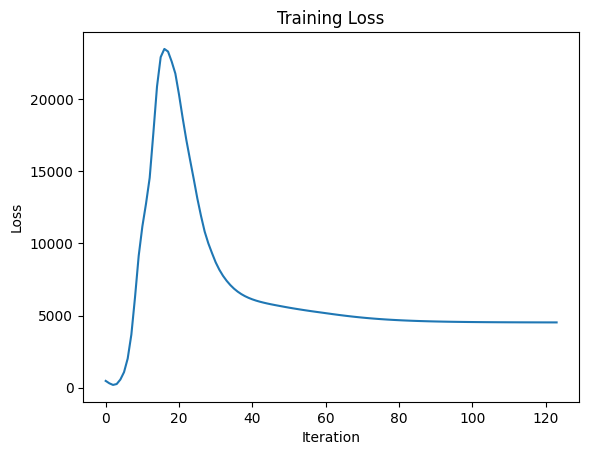

In [ ]:
# retrieve the best hyperparameters
best_params = {'dropout_rate': 0.2289625060750154,
 'learning_rate': 0.0008599429411664891,
 'activation': 'sigmoid',
 'kernel_initializer': 'glorot_normal'}

# Train the model with the best hyperparameters


# Load the training data
train_data = np.array(df.head(10000))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)

# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 300

# Define the optimization algorithm
optimizer = SGD(learning_rate=best_params["learning_rate"], momentum=0.9, nesterov=True)

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(scheduler)


moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
    input_dim,
    output_dim,
    expert_hidden_sizes,
    expert_output_sizes,
    gating_hidden_sizes,
    num_experts,
    best_params["learning_rate"],
    best_params["activation"],
    best_params["kernel_initializer"],
    best_params["dropout_rate"])


all_trainable_variables = []
for expert in experts:
    all_trainable_variables.extend(expert.trainable_variables)
all_trainable_variables.extend(gating_model.trainable_variables)
optimizer.build(all_trainable_variables)

# Initialize variables to keep track of the lowest loss and corresponding weights
lowest_loss = float('inf')
best_weights = None

# create an empty list to store the loss values
losses = []
iterations = []

# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))
    
    # Check if the current loss is lower than the lowest loss so far
    if train_loss < lowest_loss:
        lowest_loss = train_loss
        # Save the current weights as the best weights
        best_weights = moe_model.get_weights()

    # add the loss to the list
    losses.append(train_loss)

    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-8:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break
    iterations.append(iteration + 1)  # Store the iteration number
    iteration += 1

# Plot the loss function values over the training iterations
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

moe_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

moe_model.save('moe_models11.h5')
gating_model.save('gating_models11.h5')
for i, expert in enumerate(experts):
    expert.save(f'experts11_{i}.h5')